In [0]:
!pip install catboost
!pip install tsfresh
!pip install xgboost
!pip install shap

    100% |████████████████████████████████| 55.5MB 945kB/s 


    100% |████████████████████████████████| 1.2MB 16.0MB/s 
    100% |████████████████████████████████| 225kB 6.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/3a/5d/18/1f604dd6b90e4e9059263f4c589d57934c0efbf6c726b75898
Successfully built shap


In [0]:
# The essentials
import pandas as pd
import numpy as np

from collections import defaultdict

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor

# TSFRESH Feature Extraction
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from collections import defaultdict, Counter
from scipy.stats import norm

from scipy.stats import boxcox, boxcox_normmax
from scipy.special import inv_boxcox

from sklearn.preprocessing import PowerTransformer, StandardScaler

import shap

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
hcsta_features_3_3.csv
last_cleane

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')
all_data = pd.concat([train_df, test_df], axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
train_df = train_df[train_df['phase'] != 'final_rinse']

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)

In [0]:
recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse_num'] = recipe_df['pre_rinse'] * 1
recipe_df['caustic_num'] = recipe_df['caustic'] * 2
recipe_df['intermediate_rinse_num'] = recipe_df['intermediate_rinse'] * 4
recipe_df['acid_num'] = recipe_df['acid'] * 8
recipe_df['recipe'] = recipe_df['pre_rinse_num'] + recipe_df['caustic_num'] + recipe_df['intermediate_rinse_num'] + recipe_df['acid_num']

In [0]:
ts_real = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'target_value',
    'flow_diff',
    'supply_flow_log',
    'return_flow_log'
]

# variables we'll use to create our time series features
ts_cols = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'target_value',
    'flow_diff',
    #'supply_flow_log',
    #'return_flow_log'
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level',
    'tank_lsh_caustic',
    'tank_lsh_acid',
    'tank_lsh_clean_water',
    'tank_lsh_pre_rinse'
]

process_comb_to_phases = {
    15: ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid'],
    3:  ['pre_rinse', 'caustic'],
    7:  ['pre_rinse', 'caustic', 'intermediate_rinse'],
    1:  ['pre_rinse'],
    8:  ['acid'],
    2:  ['caustic'],
    6:  ['caustic', 'intermediate_rinse'],
    14: ['caustic', 'intermediate_rinse', 'acid'],
}

# phases, ordered from earliest to latest
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']

def encode_categorical(df):
    # Currently just copy-pasted from http://drivendata.co/blog/rinse-over-run-benchmark/
    
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline', 'object_id']].drop_duplicates().set_index('process_id') 
    meta['object_id'] = meta['object_id'] // 10
    #meta = meta.merge(recipe_df[['recipe', 'pre_rinse', 'caustic', 'intermediate_rinse', 'acid']], left_index=True, right_index=True)
    #meta = meta.merge(process_combinations[['phase_int']], left_index=True, right_index=True)
    
    #meta = meta.merge(df.groupby('process_id')[['timestamp']].min(), left_index=True, right_index=True)
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta, columns=['pipeline', 'object_id'])
    
    # pipeline L12 not in test data (so useless feature)
    if 'pipeline_L12' in meta:
        meta = meta.drop('pipeline_L12', axis=1)
    
    #meta['dow'] = meta['timestamp'].apply(lambda x: x.weekday())
    #meta['hour'] = meta['timestamp'].apply(lambda x: x.hour)
    
    # calculate number of phases for each process_object
    #meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    #meta['object_id'] = df.groupby('process_id')['object_id'].median()
    
    #meta = meta.drop('timestamp', axis=1)
    
    return meta
  
def count_zeros(x):
  return np.sum(x == 0)
  
def encode_real_timeseries(df):   
    ts_df = df[['process_id'] + ts_cols].set_index('process_id')
    
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', 
                                                   'count', 'median', 'sum', 
                                                   lambda x: x.tail(5).mean(),
                                                   count_zeros])
    
    cols = []
    for col in ts_features.columns:
        cols.append('real_{}'.format(col))
    ts_features.columns = cols
    
    return ts_features

def encode_binary_timeseries(df):
    ts_df = df[['process_id'] + bin_cols].set_index('process_id')
            
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['mean', 'std', 
                                                   lambda x: x.tail(5).mean(),
                                                   count_zeros])
    
    cols = []
    for col in ts_features.columns:
        cols.append('bin_{}'.format(col))
    ts_features.columns = cols
    
    return ts_features

def get_descript(data, functions, cols):
    ts_df = data.set_index('process_id').sort_values(by='timestamp')
    return ts_df.groupby('process_id')[cols].agg(functions)  

  
def get_descript_prev_process(data, data_procs):
    machines = set(data['object_id'])
    all_features = []
    for machine in tqdm(machines):
        machine_data = data[data['object_id'] == machine]
        machine_data = machine_data.sort_values(by='timestamp')
        machine_processes = machine_data['process_id'].unique()
        for process_ix, process in enumerate(machine_processes):
          if process in data_procs:
            if process_ix > 0:
                prev_process = machine_data[machine_data['process_id'] == machine_processes[process_ix - 1]]
                # TODO: Makes more sense to take first phase (since masking is done from the end)
                # this could still be another phase than pre_rinse though...
#                 first_phase = None
#                 for phase in phases:
#                   if phase in set(prev_process['phase']):
#                     first_phase = phase
#                     break
#                 prev_process = prev_process[prev_process['phase'] == first_phase]
                
#                 features = get_descript(prev_process, ['mean', 'std', 'min', 'max', 'sum'], ts_cols)
#                 _columns = list(features.columns)
#                 assert len(features) == 1
#                 features = features.iloc[0, :].values
                
                this_process = machine_data[machine_data['process_id'] == machine_processes[process_ix]]
                prev_recipe = recipe_df.loc[machine_processes[process_ix - 1]]['recipe']
#                 prev_phase_int = process_combinations.loc[machine_processes[process_ix - 1]]['phase_int']
                # From start to start, since these values are always provided (real end could be masked in test set)
                time_delta = (this_process['timestamp'].values[0] - prev_process['timestamp'].values[0]) / np.timedelta64(1, 'h')
                assert time_delta > 0
                all_features.append([machine, process, time_delta, prev_recipe])
            else:
                all_features.append([machine, process, np.NaN, np.NaN])
   
    all_features = pd.DataFrame(all_features, columns=['object_id', 'process_id', 'time_delta', 'recipe'])
    all_features = all_features.set_index('process_id', drop=True)
    col_map = {}
    for col in all_features.columns:
        col_map[col] = 'prev_{}'.format(col)
    all_features = all_features.rename(columns=col_map)
    all_features = all_features.drop('prev_object_id', axis=1)
    return all_features
  
def get_tsfresh_features(df):
    extraction_settings = EfficientFCParameters()
#     filtered_funcs = ['last_location_of_maximum', 'first_location_of_maximum', 'longest_strike_below_mean', 'last_location_of_minimum',
#                       'absolute_sum_of_changes', 'skewness', 'kurtosis', 'longest_strike_above_mean']
    filtered_funcs = ['abs_energy', 'mean_abs_change', 'mean_change', 
                      'skewness', 'kurtosis', 'absolute_sum_of_changes', 
                      'longest_strike_below_mean', 'longest_strike_above_mean', 
                      'count_above_mean', 'count_below_mean', 'last_location_of_maximum', 
                      'first_location_of_maximum', 'last_location_of_minimum', 
                      'first_location_of_minimum', 
                      'percentage_of_reoccurring_datapoints_to_all_datapoints', 
                      'percentage_of_reoccurring_values_to_all_values', 
                      'sum_of_reoccurring_values', 'sum_of_reoccurring_data_points', 
                      'ratio_value_number_to_time_series_length', 'maximum', 'minimum', 
                      'cid_ce', 'symmetry_looking', 'large_standard_deviation', 'quantile', 
                      'autocorrelation', 'number_peaks', 'binned_entropy', 'index_mass_quantile', 
                      'linear_trend',  'number_crossing_m']
#     new_funcs = ['augmented_dickey_fuller', 'number_cwt_peaks', 'agg_autocorrelation',
#                'spkt_welch_density', 'friedrich_coefficients', 'max_langevin_fixed_point',
#                'c3', 'ar_coefficient', 'mean_second_derivative_central', 'ratio_beyond_r_sigma',
#                'energy_ratio_by_chunks', 'partial_autocorrelation',
#                'fft_aggregated', 'time_reversal_asymmetry_statistic', 'range_count']
#     filtered_funcs += new_funcs
    filtered_settings = {}
    for func in filtered_funcs:
      filtered_settings[func] = extraction_settings[func]

    ts_features = extract_features(df[['process_id', 'timestamp', 'return_turbidity', 'return_flow', 'supply_flow', 'target_value', 'flow_diff']], 
                                   column_id='process_id', column_sort="timestamp", 
                                   column_kind=None, column_value=None,
                                   impute_function=impute, 
                                   default_fc_parameters=filtered_settings,
                                   show_warnings=False)
  
    return ts_features
                                       

def create_feature_matrix(df, processes, phases):
    df['return_flow'] = df['return_flow'].apply(lambda x: max(x, 0))
    df['supply_flow'] = df['supply_flow'].apply(lambda x: max(x, 0))
    df['target_value'] = df['return_flow'] * df['return_turbidity']
    df['flow_diff'] = df['supply_flow'] - df['return_flow']
    
    #df['return_flow_log'] = np.log1p(df['return_flow'])
    #df['supply_flow_log'] = np.log1p(df['supply_flow'])
    
    phase_data = df[(df['process_id'].isin(processes)) &
                    ((df['phase'].isin(phases)))]
    
    #prev_features = get_descript_prev_process(df, processes)
    #prev_features = pd.get_dummies(prev_features, columns=['prev_recipe'])
    
    metadata = encode_categorical(phase_data)
    time_series = encode_real_timeseries(phase_data)
    binary_features = encode_binary_timeseries(phase_data)
    
    if len(phases) > 1:
      last_phase_data = phase_data[phase_data['phase'] == phases[-1]]
      time_series_last_phase = encode_real_timeseries(last_phase_data)
      new_cols = []
      for col in time_series_last_phase.columns:
        new_cols.append('last_{}'.format(col))
      time_series_last_phase.columns = new_cols
      binary_features_last_phase = encode_binary_timeseries(last_phase_data)
      new_cols = []
      for col in binary_features_last_phase.columns:
        new_cols.append('last_{}'.format(col))
      binary_features_last_phase.columns = new_cols
    
    tsfresh_features = get_tsfresh_features(phase_data)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = metadata
    feature_matrix = feature_matrix.merge(time_series, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(binary_features, left_index=True, right_index=True)
    #feature_matrix = feature_matrix.merge(prev_features, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(tsfresh_features, left_index=True, right_index=True)
    
    if len(phases) > 1:
      feature_matrix = feature_matrix.merge(time_series_last_phase, left_index=True, right_index=True)
      feature_matrix = feature_matrix.merge(binary_features_last_phase, left_index=True, right_index=True)
      
#     transformer = PowerTransformer()
#     cols = feature_matrix.columns
#     indices = feature_matrix.index
#     feature_matrix = transformer.fit_transform(feature_matrix)
#     feature_matrix = pd.DataFrame(feature_matrix, index=indices, columns=cols)
    
    return feature_matrix
    
  
def get_processes(data, phases, train=True):
    filtered_processes = []
    phases = set(phases)
    processes = set(data['process_id'])
    for process in processes:
        process_phases = set(data[data['process_id'] == process]['phase'])
        if train:
            if phases.issubset(process_phases):
                filtered_processes.append(process)
        else:
            if len(phases) == len(process_phases) == len(phases.intersection(process_phases)):
                filtered_processes.append(process)
    return filtered_processes

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

def mape_1_row(x):
  return abs(x['prediction'] - x['target']) / max(290000, x['target'])

def mape_xgb(preds, dtrain):
  grad = -100*((preds-dtrain)/dtrain)
  hess = 100/(dtrain)
  return grad,hess

class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)

In [0]:
# Now train 4 models, for combinations [1, 3, 7 and 15]
total_error = 0
weights = {1: 0.1, 3: 0.9}#, 7: 0.3, 15: 0.3}
for process_combination in [1, 3]:
  train_processes = get_processes(recipe_3_train, process_comb_to_phases[process_combination])
  test_processes = get_processes(recipe_3_test, process_comb_to_phases[process_combination])
  
  train_phase_data = train_df[(train_df['process_id'].isin(train_processes)) &
                              ((train_df['phase'].isin(process_comb_to_phases[process_combination])))]
  test_phase_data = test_df[(test_df['process_id'].isin(test_processes)) &
                            ((test_df['phase'].isin(process_comb_to_phases[process_combination])))]
  
  all_phase_data = pd.concat([train_phase_data, test_phase_data], axis=0)
  phase_features = create_feature_matrix(all_phase_data)
  
  extra_processes = get_processes(recipe_15_train, process_comb_to_phases[process_combination])
  extra_data = train_df[(train_df['process_id'].isin(extra_processes)) &
                        ((train_df['phase'].isin(process_comb_to_phases[process_combination])))]
  X_extra = create_feature_matrix(extra_data)
  y_extra = np.log(label_df.loc[X_extra.index]['final_rinse_total_turbidity_liter'])
  
  X = phase_features.loc[list(set(train_phase_data['process_id']))]
  X_lb_test = phase_features.loc[list(set(test_phase_data['process_id']))]
  
  y = np.log(label_df.loc[X.index]['final_rinse_total_turbidity_liter'])
  
  print('ALL TRAIN = {} || ALL TEST = {}'.format(X.shape, X_lb_test.shape))
  
  kf = KFold(n_splits=3, random_state=2019)
  mapes = []
  for train_idx, test_idx in kf.split(X, y):
    X_train = X.iloc[train_idx, :]
    X_test = X.iloc[test_idx, :]
    
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
    val_idx = list(set(X_train.index) - set(train_idx))

    X_val = X_train.loc[val_idx, :]
    y_val = y_train.loc[val_idx]
    X_train = X_train.loc[train_idx, :]
    y_train = y_train.loc[train_idx]
    
    common_cols = list(set(X_train.columns).intersection(set(X_extra.columns)))
    X_train = X_train[common_cols]
    X_val = X_val[common_cols]
    X_test = X_test[common_cols]
    X_extra_sub = X_extra[common_cols]
    
    X_train = pd.concat([X_train, X_extra_sub], axis=0)
    y_train = pd.concat([y_train, y_extra], axis=0)
    
    print('CV TRAIN = {} || CV VAL = {} || CV TEST = {}'.format(X_train.shape, X_val.shape, X_test.shape))
    
    cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.33,
                          loss_function='MAPE', eval_metric=MAPEMetric(), l2_leaf_reg=10, random_strength=5)
    cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
    
    mape = custom_mape(np.exp(cat.predict(X_test)), np.exp(y_test))
    print('TEST MAPE = {}'.format(mape))
    mapes.append(mape)
    
  print('Combination = {}, MAPE = {}+-{}'.format(process_combination, np.mean(mapes), np.std(mapes)))
  total_mape += np.mean(mapes)*weights[process_combination]
  
print('Weighted MAPE = {}'.format(total_mape))

In [0]:
X_train[common_cols].shape, X_extra[common_cols].shape

In [0]:
from sklearn.base import clone

def fit_stack(clf, name, X_train, y_train, X_test, n_splits=5):
  scaler = StandardScaler()
  cols = X_train.columns
  train_idx = X_train.index
  test_idx = X_test.index
  X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols, index=train_idx)
  X_test = pd.DataFrame(scaler.transform(X_test), columns=cols, index=test_idx)
  
  train_predictions = np.zeros((len(X_train),))
  test_predictions = np.zeros((len(X_test), n_splits))
  kf = KFold(n_splits=n_splits, shuffle=True)
  for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    X_cv_train = X_train.iloc[train_idx, :]
    X_cv_test = X_train.iloc[test_idx, :]
    y_cv_train = y_train.iloc[train_idx]
    y_cv_test = y_train.iloc[test_idx]
    
    clf_clone = clone(clf)
    clf_clone.fit(X_cv_train, y_cv_train)
    
    print('[{}] Fold #{} MAPE={}'.format(name, fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(clf_clone.predict(X_cv_test)))))
    
    train_predictions[test_idx] = np.minimum(np.max(y_cv_train), np.maximum(0, clf_clone.predict(X_cv_test)))
    test_predictions[:, fold_ix] = np.minimum(np.max(y_cv_train), np.maximum(0, clf_clone.predict(X_test)))
    
  train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_pred'.format(name)])
  # Taking min instead of mean, since undershooting is better than overshooting for MAPE
  test_predictions_df = pd.DataFrame(np.min(test_predictions, axis=1), index=X_test.index, columns=['{}_pred'.format(name)])
    
  return train_predictions_df, test_predictions_df

In [11]:
combinations_per_recipe = {
    3: [1, 2, 3], #1, 2, 
    9: [8],
    15: [7, 15] # 2, 6, 14
}

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15, 9, 3]:
    recipe_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == recipe].index)]
    recipe_test_data = test_df[test_df['process_id'].isin(recipe_df[recipe_df['recipe'] == recipe].index)]
    for process_combination in combinations_per_recipe[recipe]:
      print('Recipe = {} || Combination = {}'.format(recipe, process_combination))
      train_processes = get_processes(recipe_train_data, process_comb_to_phases[process_combination])
      test_processes = get_processes(recipe_test_data, process_comb_to_phases[process_combination], train=False)
      all_processes = train_processes + test_processes

      phase_features = create_feature_matrix(all_data, all_processes, process_comb_to_phases[process_combination])

      X_train = phase_features.loc[train_processes]
      X_test = phase_features.loc[test_processes]

      y_train = np.log(label_df.loc[X_train.index]['final_rinse_total_turbidity_liter'])
      
      to_drop = remove_features(X_train, y_train)
      print(len(to_drop), to_drop)

      X_train = X_train.drop(to_drop, axis=1)
      X_test = X_test.drop(to_drop, axis=1)
      
      if (recipe, process_combination) in [(9, 8)]:
          if recipe == 9:
            recipe_15_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)]
          else:
            recipe_15_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 3].index)]
            
          extra_processes = get_processes(recipe_15_train_data, process_comb_to_phases[process_combination])
          extra_phase_data = train_df[(train_df['process_id'].isin(extra_processes)) &
                                      ((train_df['phase'].isin(process_comb_to_phases[process_combination])))]
          extra_phase_features = create_feature_matrix(all_data, extra_processes, process_comb_to_phases[process_combination])
          X_extra = extra_phase_features.loc[list(set(extra_phase_data['process_id']))]
          y_extra = np.log(label_df.loc[X_extra.index]['final_rinse_total_turbidity_liter'])
          
          for col in set(X_train.columns) - set(X_extra.columns):
              X_extra[col] = 0
          X_extra = X_extra[X_train.columns]

          X_train = pd.concat([X_train, X_extra])
          y_train = pd.concat([y_train, y_extra])
        
      clfs = [
          ('knn', GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10, 25, 100]})),
          ('lr', GridSearchCV(Lasso(max_iter=10000), {'alpha': [1.0, 10.0, 100.0, 1000.0]})),
          ('knn_pca', GridSearchCV(
              Pipeline(steps=[('pca', PCA()), ('knn', KNeighborsRegressor())]),
              {'knn__n_neighbors': [10, 25, 100], 'pca__n_components': [5, 10, 25]}
            )
          ),
          ('mlp', GridSearchCV(MLPRegressor(max_iter=1000), {'hidden_layer_sizes': [(100,), (250,), (100, 100)]})),
          ('rf_25', RandomForestRegressor(n_estimators=25)),
          ('rf_100', RandomForestRegressor(n_estimators=100)),
          ('rf_250', RandomForestRegressor(n_estimators=250)),
          ('et_25', ExtraTreesRegressor(n_estimators=25)),
          ('et_100', ExtraTreesRegressor(n_estimators=100)),
          ('et_250', ExtraTreesRegressor(n_estimators=250)),
          #('tsne_knn', Pipeline(steps=[('tsne', TSNE(n_components=2)), ('knn', GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10, 25, 100]}))]))
      ]

      for name, clf in clfs:
          train_pred_df, test_pred_df = fit_stack(clf, name, X_train, y_train, X_test, n_splits=5)
          X_train = pd.concat([X_train, train_pred_df], axis=1)
          X_test = pd.concat([X_test, test_pred_df], axis=1)

      train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
      val_idx = list(set(X_train.index) - set(train_idx))

      X_val = X_train.loc[val_idx, :]
      X_train = X_train.loc[train_idx, :]
      y_val = y_train.loc[val_idx]
      y_train = y_train.loc[train_idx]
      
      print(X_train.shape, X_val.shape, X_test.shape)

      cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.33,
                              loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
      cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)

      predictions = np.exp(cat.predict(X_test))

      sub_predictions_df = pd.DataFrame(predictions, columns=['final_rinse_total_turbidity_liter'])
      sub_predictions_df.index = X_test.index
      sub_predictions_df.index.name = X_test.index.name
      sub_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/predictions_{}_{}.csv'.format(recipe, process_combination))

      if prediction_df is None:
          prediction_df = sub_predictions_df
      else:
          prediction_df = pd.concat([prediction_df, sub_predictions_df])

      del cat

Recipe = 15 || Combination = 7


Feature Extraction: 100%|██████████| 5/5 [05:11<00:00, 62.24s/it]


970 correlated feature pairs left...
930 correlated feature pairs left...
892 correlated feature pairs left...
850 correlated feature pairs left...
814 correlated feature pairs left...
774 correlated feature pairs left...
736 correlated feature pairs left...
700 correlated feature pairs left...
666 correlated feature pairs left...
634 correlated feature pairs left...
604 correlated feature pairs left...
576 correlated feature pairs left...
550 correlated feature pairs left...
526 correlated feature pairs left...
492 correlated feature pairs left...
470 correlated feature pairs left...
438 correlated feature pairs left...
418 correlated feature pairs left...
388 correlated feature pairs left...
360 correlated feature pairs left...
334 correlated feature pairs left...
316 correlated feature pairs left...
314 correlated feature pairs left...
298 correlated feature pairs left...
284 correlated feature pairs left...
260 correlated feature pairs left...
258 correlated feature pairs left...
2

Feature Extraction: 100%|██████████| 5/5 [05:22<00:00, 64.37s/it]


926 correlated feature pairs left...
888 correlated feature pairs left...
852 correlated feature pairs left...
810 correlated feature pairs left...
770 correlated feature pairs left...
732 correlated feature pairs left...
696 correlated feature pairs left...
662 correlated feature pairs left...
630 correlated feature pairs left...
600 correlated feature pairs left...
572 correlated feature pairs left...
538 correlated feature pairs left...
506 correlated feature pairs left...
504 correlated feature pairs left...
478 correlated feature pairs left...
454 correlated feature pairs left...
424 correlated feature pairs left...
396 correlated feature pairs left...
374 correlated feature pairs left...
354 correlated feature pairs left...
336 correlated feature pairs left...
320 correlated feature pairs left...
294 correlated feature pairs left...
280 correlated feature pairs left...
256 correlated feature pairs left...
254 correlated feature pairs left...
232 correlated feature pairs left...
2

Feature Extraction: 100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


592 correlated feature pairs left...
590 correlated feature pairs left...
544 correlated feature pairs left...
500 correlated feature pairs left...
458 correlated feature pairs left...
418 correlated feature pairs left...
380 correlated feature pairs left...
344 correlated feature pairs left...
310 correlated feature pairs left...
278 correlated feature pairs left...
248 correlated feature pairs left...
246 correlated feature pairs left...
218 correlated feature pairs left...
216 correlated feature pairs left...
214 correlated feature pairs left...
188 correlated feature pairs left...
164 correlated feature pairs left...
162 correlated feature pairs left...
140 correlated feature pairs left...
120 correlated feature pairs left...
118 correlated feature pairs left...
100 correlated feature pairs left...
84 correlated feature pairs left...
70 correlated feature pairs left...
68 correlated feature pairs left...
66 correlated feature pairs left...
64 correlated feature pairs left...
52 cor

Feature Extraction: 100%|██████████| 5/5 [04:10<00:00, 50.01s/it]


[knn] Fold #1 MAPE=0.8769694599938307
[knn] Fold #2 MAPE=0.7085248288893022
[knn] Fold #3 MAPE=1.045741244542704
[knn] Fold #4 MAPE=0.8507863996533851
[knn] Fold #5 MAPE=0.7737897285478585
[lr] Fold #1 MAPE=2.3727535782946014
[lr] Fold #2 MAPE=1.9283724487099083
[lr] Fold #3 MAPE=2.010565021052719
[lr] Fold #4 MAPE=1.8713050587007816
[lr] Fold #5 MAPE=2.0862534688521275
[knn_pca] Fold #1 MAPE=0.8300459040079011
[knn_pca] Fold #2 MAPE=1.0547178166671232
[knn_pca] Fold #3 MAPE=0.9212224794488911
[knn_pca] Fold #4 MAPE=0.7678390488082872
[knn_pca] Fold #5 MAPE=0.89603675646069
[mlp] Fold #1 MAPE=0.839942762860918
[mlp] Fold #2 MAPE=1.3634501120345275
[mlp] Fold #3 MAPE=0.8181198663707899
[mlp] Fold #4 MAPE=0.9975400243806011
[mlp] Fold #5 MAPE=1.0537959612426162
[rf_25] Fold #1 MAPE=0.75792581491048
[rf_25] Fold #2 MAPE=0.8337740726221026
[rf_25] Fold #3 MAPE=0.8312994762845521
[rf_25] Fold #4 MAPE=0.7459591291550265
[rf_25] Fold #5 MAPE=0.5332457553327905
[rf_100] Fold #1 MAPE=0.96741523

Feature Extraction: 100%|██████████| 5/5 [01:44<00:00, 20.87s/it]


1056 correlated feature pairs left...
1014 correlated feature pairs left...
972 correlated feature pairs left...
970 correlated feature pairs left...
930 correlated feature pairs left...
892 correlated feature pairs left...
856 correlated feature pairs left...
854 correlated feature pairs left...
852 correlated feature pairs left...
812 correlated feature pairs left...
778 correlated feature pairs left...
740 correlated feature pairs left...
708 correlated feature pairs left...
678 correlated feature pairs left...
642 correlated feature pairs left...
608 correlated feature pairs left...
576 correlated feature pairs left...
548 correlated feature pairs left...
518 correlated feature pairs left...
492 correlated feature pairs left...
468 correlated feature pairs left...
458 correlated feature pairs left...
436 correlated feature pairs left...
416 correlated feature pairs left...
398 correlated feature pairs left...
382 correlated feature pairs left...
380 correlated feature pairs left...

In [0]:
prediction_df = prediction_df.sort_index()
prediction_df.index.name = X_test.index.name
prediction_df = prediction_df.sort_index()
prediction_df.to_csv('/content/drive/My Drive/Rinse Over Run/stacking_v2_not_all_models.csv')

In [0]:
len(prediction_df)

In [0]:
#from tsfresh.feature_selection.relevance import calculate_relevance_table

def get_corr_features(X):
  row_idx, col_idx = np.where(X.corr() == 1)
  self_corr = set([(i, i) for i in range(X.shape[1])])
  return set(list(zip(row_idx, col_idx))) - self_corr 

def get_uncorr_features(data):
  X_train_corr = data.copy()
  correlated_features = get_corr_features(X_train_corr)
  
  corr_cols = set()
  for row_idx, col_idx in correlated_features:
    corr_cols.add(row_idx)
    corr_cols.add(col_idx)
  
  uncorr_cols = list(set(X_train_corr.columns) - set(X_train_corr.columns[list(corr_cols)]))
   
  col_mask = [False]*X_train_corr.shape[1]
  for col in corr_cols:
    col_mask[col] = True
  X_train_corr = X_train_corr.loc[:, col_mask]
  
  correlated_features = get_corr_features(X_train_corr)
  
  while correlated_features:
    print('{} correlated feature pairs left...'.format(len(correlated_features)))
    corr_row, corr_col = correlated_features.pop()
    col_mask = [True]*X_train_corr.shape[1]
    col_mask[corr_row] = False
    X_train_corr = X_train_corr.loc[:, col_mask]
    correlated_features = get_corr_features(X_train_corr)
  return list(set(list(X_train_corr.columns) + uncorr_cols))

def remove_features(data, target, p_val=0.25):
  single_cols = list(data.columns[data.nunique() == 1])
  
  uncorr_cols = get_uncorr_features(data)
  corr_cols = list(set(data.columns) - set(uncorr_cols))
  
#   rel_table = calculate_relevance_table(data.dropna(axis=1), target, 
#                                         ml_task='regression')
#   irrel_cols = list(rel_table[rel_table['p_value'] < p_val]['feature'])
  
#   na_cols = data.columns[data.isnull().sum() > 1]
#   data_na = data[na_cols].dropna(axis=0)
#   rel_table_na = calculate_relevance_table(data_na, target.loc[data_na.index], ml_task='regression')
#   irrel_na_cols = list(rel_table_na[rel_table_na['p_value'] < p_val]['feature'])
  
  return list(set(single_cols + corr_cols))# + irrel_cols + irrel_na_cols

def bootstrap(X_train, y_train, X_test, n_models=3):
    models = []
    predictions = []
    for _ in range(n_models):
        # Bootstrap the data
        bs_idx = np.random.choice(X_train.index, replace=True, size=len(X_train))
        X_train_bs = X_train.loc[bs_idx]
        y_train_bs = y_train.loc[bs_idx]
        
        # Create a validation set
        train_idx = np.random.choice(X_train_bs.index, replace=False, size=int(0.9 * len(X_train_bs)))
        val_idx = list(set(X_train_bs.index) - set(train_idx))

        X_val_sub = X_train_bs.loc[val_idx, :]
        y_val_sub = y_train_bs.loc[val_idx]
        X_train_sub = X_train_bs.loc[train_idx, :]
        y_train_sub = y_train_bs.loc[train_idx]
        
        # Remove useless features
        to_drop = remove_features(X_train_sub, y_train_sub)
        
        X_train_sub = X_train_sub.drop(to_drop, axis=1)
        X_val_sub = X_val_sub.drop(to_drop, axis=1)
        X_test_sub = X_test.drop(to_drop, axis=1)
        
        print(X_train_sub.shape, X_val_sub.shape)
        
        cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                                learning_rate=0.33, #depth=4, model_size_reg=1, 
                                #l2_leaf_reg=25, random_strength=10
                                loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
        cat.fit(X_train_sub, y_train_sub, eval_set=(X_val_sub, y_val_sub), verbose=50)
        
        predictions.append(cat.predict(X_test_sub))
        
    return np.min(predictions, axis=0)

In [0]:
import pickle
test_prediction_vectors = pickle.load(open('/content/drive/My Drive/Rinse Over Run/test_preds_per_phase.p', 'rb'))
all_train_prediction_vectors = pickle.load(open('/content/drive/My Drive/Rinse Over Run/all_train_preds_per_phase.p', 'rb'))

Recipe = 15 || Combination = 1


Feature Extraction: 100%|██████████| 5/5 [03:32<00:00, 42.60s/it]


1156 correlated feature pairs left...
1114 correlated feature pairs left...
1072 correlated feature pairs left...
1032 correlated feature pairs left...
994 correlated feature pairs left...
958 correlated feature pairs left...
924 correlated feature pairs left...
884 correlated feature pairs left...
852 correlated feature pairs left...
822 correlated feature pairs left...
796 correlated feature pairs left...
772 correlated feature pairs left...
750 correlated feature pairs left...
730 correlated feature pairs left...
728 correlated feature pairs left...
710 correlated feature pairs left...
708 correlated feature pairs left...
706 correlated feature pairs left...
704 correlated feature pairs left...
676 correlated feature pairs left...
650 correlated feature pairs left...
626 correlated feature pairs left...
604 correlated feature pairs left...
584 correlated feature pairs left...
566 correlated feature pairs left...
550 correlated feature pairs left...
536 correlated feature pairs left.

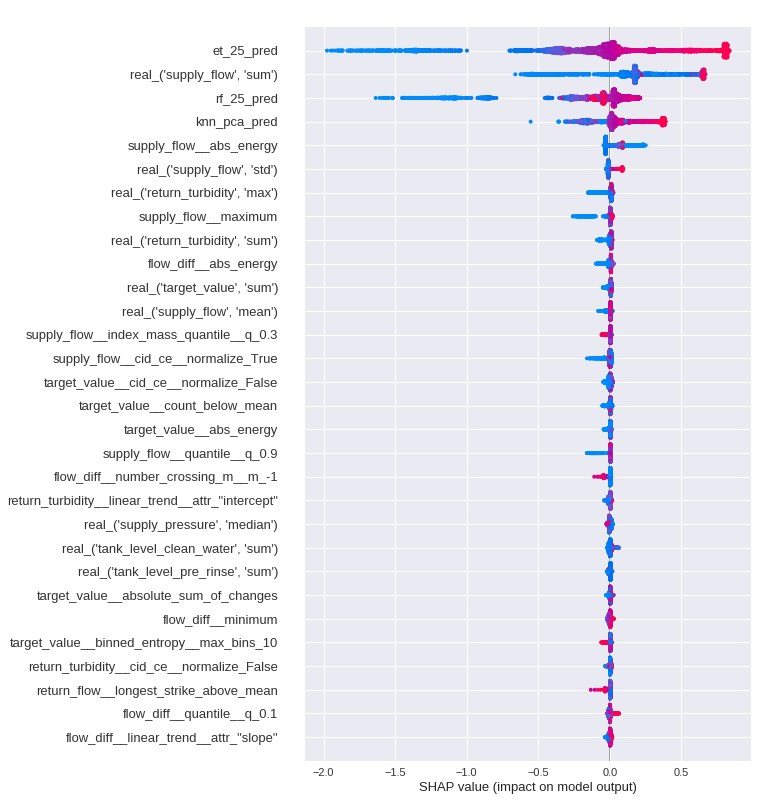

TEST MAPE = 0.2821465973050896
[knn_pca] Fold #1 MAPE=1.1874523133722623


KeyboardInterrupt: ignored

In [0]:
def xgb_mape_eval(preds, dtrain):
    labels = dtrain.get_label()
    return 'mape', np.mean(np.abs((np.exp(labels) - np.exp(preds)) / np.maximum(290000, np.exp(labels))))
  
def get_predictions(process, phases, train=True):
  preds = []
  if train:
    for phase in phases:
      if process in all_train_prediction_vectors and phase in all_train_prediction_vectors[process]:
        pred = all_train_prediction_vectors[process][phase]
        if pred > 0:
          preds.append(pred)
        else:
          preds.append(np.NaN)
      else:
        print('Did not find phase {} for train process {}'.format(phase, process))
        preds.append(np.NaN)
  else:
    for phase in phases:
      if process in test_prediction_vectors and phase in test_prediction_vectors[process]:
        pred = test_prediction_vectors[process][phase]
        if pred > 0:
          preds.append(pred)
        else:
          preds.append(np.NaN)
      else:
        preds.append(np.NaN)
        print('Did not find phase {} for test process {}'.format(phase, process))
  return preds

combinations_per_recipe = {
    3: [3],  # 2 not included
    9: [8],
    15: [1]
}

import warnings; warnings.filterwarnings('ignore')

prediction_df = None
all_mapes = defaultdict(list)
for recipe in [15]:
    recipe_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == recipe].index)]
    recipe_test_data = test_df[test_df['process_id'].isin(recipe_df[recipe_df['recipe'] == recipe].index)]
    for process_combination in combinations_per_recipe[recipe]:
      print('Recipe = {} || Combination = {}'.format(recipe, process_combination))
      train_processes = get_processes(recipe_train_data, process_comb_to_phases[process_combination])
      phase_features = create_feature_matrix(train_df, train_processes, process_comb_to_phases[process_combination])
      
      X = phase_features.loc[train_processes]
      y = np.log(label_df.loc[X.index]['final_rinse_total_turbidity_liter'])
      
#       _columns = ['pred_{}'.format(phase) for phase in process_comb_to_phases[process_combination]]
#       train_predictions_df = pd.DataFrame([get_predictions(process, process_comb_to_phases[process_combination]) for process in train_processes], columns=_columns, index=train_processes)
#       print(train_predictions_df.isnull().sum())
      
#       X = X.merge(train_predictions_df, left_index=True, right_index=True)

#       hctsa_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/hcsta_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
#       hctsa_features = hctsa_features.drop('return_flow_CO_glscf_2_5_5', axis=1)
#       print(X.shape)
#       X = X.merge(hctsa_features, left_index=True, right_index=True)
#       print(X.shape)
    
      to_drop = remove_features(X, y)
      X = X.drop(to_drop, axis=1)
    
      kf = KFold(n_splits=5, random_state=2019)
      mapes = []
      shaps = []
      for train_idx, test_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        X_test = X.iloc[test_idx, :]

        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        clfs = [
#             ('knn', GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10, 25, 100]})),
#             ('lr', GridSearchCV(Lasso(max_iter=10000), {'alpha': [1.0, 10.0, 100.0, 1000.0]})),
            ('knn_pca', GridSearchCV(
                Pipeline(steps=[('pca', PCA()), ('knn', KNeighborsRegressor())]),
                {'knn__n_neighbors': [10, 25, 100], 'pca__n_components': [5, 10, 25]}
              )
            ),
#             ('mlp', GridSearchCV(MLPRegressor(max_iter=1000), {'hidden_layer_sizes': [(100,), (250,), (100, 100)]})),
            ('rf_25', RandomForestRegressor(n_estimators=25)),
#             ('rf_100', RandomForestRegressor(n_estimators=100)),
#             ('rf_250', RandomForestRegressor(n_estimators=250)),
            ('et_25', ExtraTreesRegressor(n_estimators=25)),
#             ('et_100', ExtraTreesRegressor(n_estimators=100)),
#             ('et_250', ExtraTreesRegressor(n_estimators=250)),
            #('tsne_knn', Pipeline(steps=[('tsne', TSNE(n_components=2)), ('knn', GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10, 25, 100]}))]))
        ]
        
        for name, clf in clfs:
            train_pred_df, test_pred_df = fit_stack(clf, name, X_train, y_train, X_test)
            X_train = pd.concat([X_train, train_pred_df], axis=1)
            X_test = pd.concat([X_test, test_pred_df], axis=1)
            
        train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
        val_idx = list(set(X_train.index) - set(train_idx))

        X_val = X_train.loc[val_idx, :]
        y_val = y_train.loc[val_idx]
        X_train = X_train.loc[train_idx, :]
        y_train = y_train.loc[train_idx]
    
        if (recipe, process_combination) in [(9, 8)]:
          recipe_15_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)]
            
          extra_processes = get_processes(recipe_15_train_data, process_comb_to_phases[process_combination])
          extra_phase_data = train_df[(train_df['process_id'].isin(extra_processes)) &
                                      ((train_df['phase'].isin(process_comb_to_phases[process_combination])))]
          
          extra_phase_features = create_feature_matrix(train_df, extra_processes, process_comb_to_phases[process_combination])
          X_extra = extra_phase_features.loc[list(set(extra_phase_data['process_id']))]
          # WARNING: This does not work!!!! Use log-transform when we augment
          y_extra = np.log(label_df.loc[X_extra.index]['final_rinse_total_turbidity_liter'])

          for col in set(X_train.columns) - set(X_extra.columns):
              X_extra[col] = 0
          X_extra = X_extra[X.columns]

          X_train = pd.concat([X_train, X_extra])
          y_train = pd.concat([y_train, y_extra])
        
        
        print(list(X_train.columns))
        
        print('CV TRAIN = {} || CV VAL = {} || CV TEST = {}'.format(X_train.shape, X_val.shape, X_test.shape))

        cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                                learning_rate=0.33, #depth=4, model_size_reg=1, 
                                #l2_leaf_reg=25, random_strength=10
                                loss_function='MAPE', eval_metric='MAPE', task_type='GPU')
        cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)#, cat_features=[cat_idx]
        explainer = shap.TreeExplainer(cat)
        shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]))
#         shaps.append(shap_values)
        
        plt.figure()
        shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]), max_display=30, 
                          auto_size_plot=True, show=False, color_bar=False)
        plt.show()
        
        predictions = np.exp(cat.predict(X_test))
        mape = custom_mape(predictions, np.exp(y_test))
        print('TEST MAPE = {}'.format(mape))
        mapes.append(mape)
        all_mapes[(recipe, process_combination)].append(mape)

      print('Combination = {}, MAPE = {}+-{}'.format(process_combination, np.mean(mapes), np.std(mapes)))
#       plt.figure()
#       shap.summary_plot(np.mean(shaps, axis=0), X_train, max_display=30, 
#                         auto_size_plot=True, show=False, color_bar=False)
#       plt.show()
      
    print('Recipe {}: MAPES: {}'.format(recipe, all_mapes))
    
for k in all_mapes:
    print(k, np.mean(all_mapes[k]), np.std(all_mapes[k]))

In [0]:
# Recipe 3: MAPES: defaultdict(<class 'list'>, {(3, 3): [0.29392634932285483, 0.27901985807507057, 0.2698492901773505, 0.29783011485363575, 0.27963855404610505]})

# Recipe 15: MAPES: defaultdict(<class 'list'>, {(15, 15): [0.249012397261181, 0.26078637105196645, 0.26130547428916867, 0.25945796543598754, 0.2354016183310729]})

# (3, 1) 0.34305582057482664 0.01667236717220544
# (3, 3) 0.3025325067245938 0.012568955364118607
# (15, 1) 0.3060693051323446 0.010601032969927288
# (15, 3) 0.2849734467485759 0.011063707799029692
# (15, 7) 0.2786761570436056 0.007027916563361835
# (15, 15) 0.25033133831423837 0.006711022393455834

In [0]:
filtered_funcs = ['abs_energy', 'mean_abs_change', 'mean_change', 
                  'skewness', 'kurtosis', 'absolute_sum_of_changes', 
                  'longest_strike_below_mean', 'longest_strike_above_mean', 
                  'count_above_mean', 'count_below_mean', 'last_location_of_maximum', 
                  'first_location_of_maximum', 'last_location_of_minimum', 
                  'first_location_of_minimum', 
                  'percentage_of_reoccurring_datapoints_to_all_datapoints', 
                  'percentage_of_reoccurring_values_to_all_values', 
                  'sum_of_reoccurring_values', 'sum_of_reoccurring_data_points', 
                  'ratio_value_number_to_time_series_length', 'maximum', 'minimum', 
                  'cid_ce', 'symmetry_looking', 'large_standard_deviation', 'quantile', 
                  'autocorrelation', 'number_peaks', 'binned_entropy', 'index_mass_quantile', 
                  'linear_trend',  'number_crossing_m']
new_funcs = ['augmented_dickey_fuller', 'number_cwt_peaks', 'agg_autocorrelation',
             'spkt_welch_density', 'friedrich_coefficients', 'max_langevin_fixed_point',
             'c3', 'ar_coefficient', 'mean_second_derivative_central', 'ratio_beyond_r_sigma',
             'energy_ratio_by_chunks', 'partial_autocorrelation',
             'fft_aggregated', 'time_reversal_asymmetry_statistic', 'range_count']
all_funcs = EfficientFCParameters()
unlisted_funcs = set(all_funcs.keys()) - set(filtered_funcs)

small_df = train_df[train_df['process_id'] == 27306]

In [0]:

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
for name, clf in clfs:
    train_pred_df, test_pred_df = fit_stack(clf, name, X_train, y_train, X_test)
    X_train = pd.concat([X_train, train_pred_df], axis=1)
    X_test = pd.concat([X_test, test_pred_df], axis=1)

ValueError: ignored

In [0]:
X_train

,pipeline_L1,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,object_id_10,object_id_11,object_id_20,object_id_21,...,"last_bin_('object_low_level', '<lambda>')","last_bin_('object_low_level', 'count_zeros')","last_bin_('tank_lsh_caustic', 'mean')","last_bin_('tank_lsh_caustic', 'std')","last_bin_('tank_lsh_caustic', '<lambda>')","last_bin_('tank_lsh_caustic', 'count_zeros')","last_bin_('tank_lsh_clean_water', 'mean')","last_bin_('tank_lsh_clean_water', 'std')","last_bin_('tank_lsh_clean_water', 'count_zeros')",knn_pred
process_id,,,,,,,,,,,,,,,,,,,,,
26625,0,0,1,0,0,0,0,0,0,0,...,0.0,370,1.000000,0.000000,1.0,0,0.0,0.0,403,13.514214
24579,0,0,0,0,0,0,0,0,0,0,...,0.0,147,1.000000,0.000000,1.0,0,0.0,0.0,148,13.558524
20492,0,1,0,0,0,0,0,0,0,1,...,0.0,442,0.000000,0.000000,0.0,478,0.0,0.0,478,15.203005
22540,0,1,0,0,0,0,0,0,0,1,...,0.0,472,0.035270,0.184652,1.0,465,0.0,0.0,482,14.430128
20498,0,0,0,0,1,0,0,0,0,0,...,0.0,176,0.000000,0.000000,0.0,196,0.0,0.0,196,14.332070
24596,0,1,0,0,0,0,0,0,1,0,...,1.0,43,0.000000,0.000000,0.0,279,0.0,0.0,279,14.546340
22550,0,0,0,0,0,0,0,0,0,0,...,0.0,146,0.000000,0.000000,0.0,148,0.0,0.0,148,15.200757
24598,0,1,0,0,0,0,0,0,0,1,...,0.0,442,0.000000,0.000000,0.0,462,0.0,0.0,462,14.345573
26648,0,1,0,0,0,0,0,0,0,1,...,0.0,550,0.000000,0.000000,0.0,596,0.0,0.0,596,14.475815


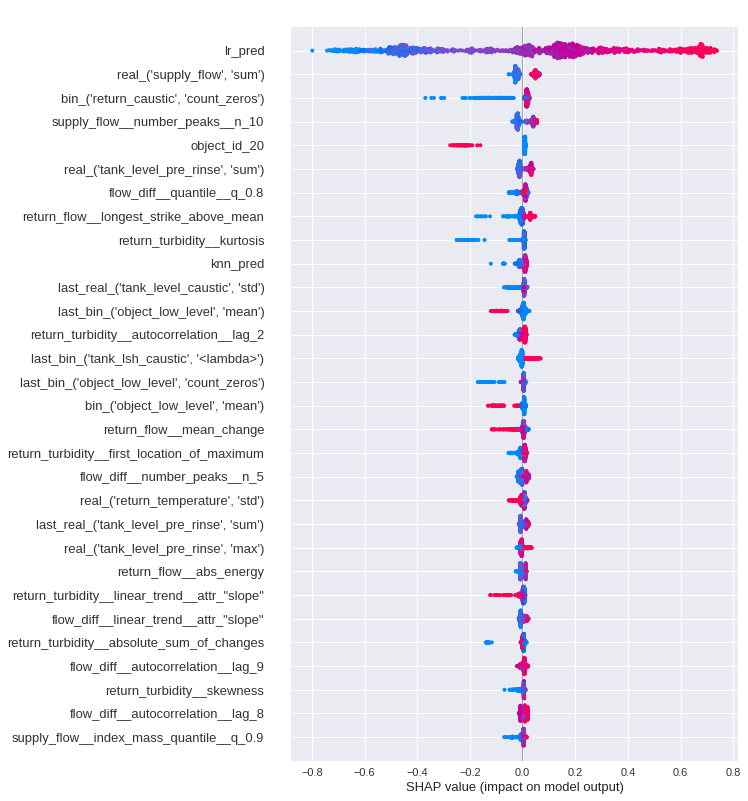

In [0]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(pd.concat([X_train, X_val, X_test]))
shap.summary_plot(shap_values, pd.concat([X_train, X_val, X_test]), max_display=30, 
                        auto_size_plot=True, show=False, color_bar=False)

In [0]:
df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/hcsta_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
df['return_flow_CO_glscf_2_5_5'].apply(lambda x: float(x.replace('(')))

ValueError: ignored